In [1]:
using Roots # For solving set of equations
using Plots
using Measurements

In [96]:
Vref = 1.24; # It is the internal Vref of the chip
η = 0.95; # 95 efficiency
Coff = 470e-12; # F
Fsw = 150e3; # Hz, no reason in particular for 500kHz
Vin = 12; # V
Vo = 3.3; # This is a small little hack I call, doing whatever I want
Co = 132e-6; # F, I think this is a good value but can be changed
MaxCurrent = 6; # Amps
MaxRipple = 0.0015; # Amps

In [97]:
RoffEstmated = -(1 - (Vo / (η*Vin)))/((Coff+20e-12)*Fsw*log(1-Vref/Vo))

20515.039262376886

In [98]:
Roff = 24.9e3; # Closest to 1% metal film values
tOff = -(Coff + 20e-12)*Roff*log(1-Vref/Vo);
FswActual = (1-(Vo/(η*Vin)))/tOff #Uncomment me for the actual fsw

#FswActual = 100e3 # this is for testing what would happen to the inductors and capacitors with a lower fsw

123584.57386974027

In [99]:
# Peltier resistance approximation at max current, it is not a replacement for 
# the peltier in simulations
V1, V2 = 3.213, 3.821;
I1, I2 = 4.8, 6;
rTec = (V2 - V1) / (I2 - I1)


0.5066666666666667

In [100]:
CurrentRipple(L, Vref) = -(Vo*Roff*(Coff+20e-12)*log(1-Vref/Vo))/L;
CapacitorCorrectedRipple(L, Vref) = CurrentRipple(L, Vref) / (1 + (rTec*2*π*FswActual*Co));
Iout(L, Rsns, Vref) = (Vref/(5*Rsns)) - 0.5*CapacitorCorrectedRipple(L, Vref);

In [101]:
# Calculates appropiate Inductor
LCalculated = find_zero(L -> CapacitorCorrectedRipple(L, Vref) - MaxRipple, 10e-6) 

0.0002389544002881881

In [94]:
# Then calculate Rsns (find it between 0 and 1 ohms)
RsnsCalculated = find_zero(Rsns -> Iout(LCalculated, Rsns, Vref) - MaxCurrent, (0.0, 1))

0.04132816731241928

In [102]:
RsnsActual = 0.04;
RsnsWError = RsnsActual ± 1.2*RsnsActual/100
LActual = 150e-6;
LWError = LActual ± LActual*20/100;

# Actual current and ripple with realistic values
IoutActual, IrippleActual = Iout(LActual, RsnsActual, Vref), CapacitorCorrectedRipple(LActual, Vref)
IoutwError, IripplewError = Iout(LWError, RsnsWError, Vref), CapacitorCorrectedRipple(LWError, Vref)

(6.199 ± 0.074, 0.00239 ± 0.00048)

In [22]:
tOnActual = 1/FswActual - tOff;
Cin = IrippleActual*tOnActual / (0.05*Vin)

#Cin is nanofarad range, so we will stick with 1uF

1.2239535866741936e-8

In [23]:
Vhys = 1
Von = 3.5 # If it drops below this, it wont work as a buck converter anymore
Ru2 = Vhys / 22e-6
Ru1 = 1.24*Ru2 / (Von - 1.24)

@show Ru2, Ru1

(Ru2, Ru1) = (45454.545454545456, 24939.662107803706)


(45454.545454545456, 24939.662107803706)

In [24]:
RdsON = 17e-3;

D = V2/(Vin*η)
It = D*IoutActual # Minimum current rating of the mosfet

ItRMS = IoutActual*√(D*(1+(1/12)*(IrippleActual/IoutActual)^2))
Pt = RdsON*ItRMS^2 

print("The MOSFET will dissipate $Pt W of power!")


The MOSFET will dissipate 0.21891970397135352 W of power!

In [25]:
# Diode dissipation calculations
Vf = 0.38 # Diode forward voltage @ 7A
Pdis = 40 # K / W
ID = (1-D)*IoutActual
PD = ID*Vf

TDrise = Pdis / PD

print("The diode will dissipate $PD which induces a temperature rise of $TDrise")

The diode will dissipate 1.5659306330678677 which induces a temperature rise of 25.543915646911284

In [16]:
1/(2*π*9.53e3*100e-9)

167.00413755707802

25e3*10e-6

In [2]:
(3.3-3.2) / 100e-6

999.9999999999964

In [6]:
(12-3.2) / 0.2e-3

44000.0

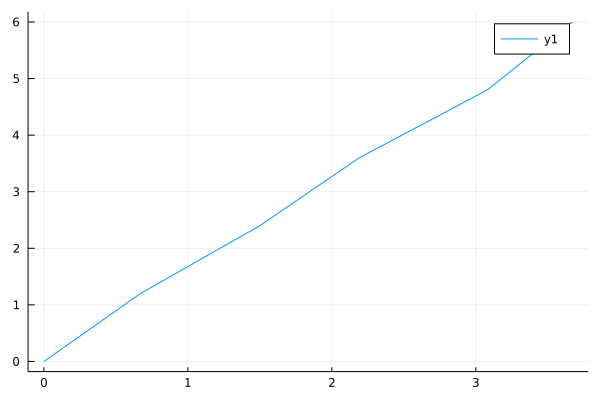

In [2]:
vpeltier = [0.0, 0.67, 1.5, 2.19, 3.08, 3.67]
ipeltier = [0.0, 1.2, 2.4, 3.6, 4.8, 6]

using Plots

plot(vpeltier, ipeltier)

In [26]:
using DataFrames, GLM

data = DataFrame(X=vpeltier, Y=ipeltier)

ols = lm(@formula(Y ~ X), data)

┌ Info: Precompiling GLM [38e38edf-8417-5370-95a0-9cbb8c7f171a]
└ @ Base loading.jl:1278


LoadError: [91mUndefVarError: vpeltier not defined[39m

In [81]:

tONmin = 221e-9
VoSimpified(D) = D*(Vin + Vf) - Vf
VoFull(D) = (D*(Vin + Vf) - Vf) / ((RdsON*D/rTec) + 1)

minVo = find_zero(f -> VoFull(f), 0.5) 

0.030694668820678513

In [82]:
minVoFull(f) = VoFull(f*tONmin)

minVoFull (generic function with 1 method)

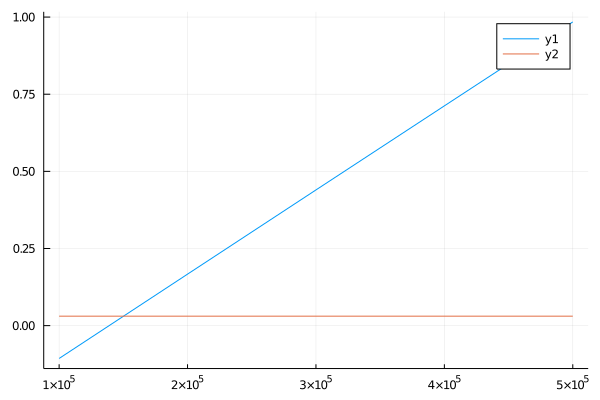

In [83]:
plot(100e3:100e3:500e3, x -> minVoFull(x))
plot!(100e3:100e3:500e3, x -> minVo)


In [86]:
minFreq = find_zero(f -> fCompFreq(f) - minVo, 200e3) 

150121.28640460942

In [85]:
minVo / rTec

0.060581583198707586